<a href="https://colab.research.google.com/github/amanvishnani/CSCI-6505/blob/master/A4_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Group Members**



*   Aman Vishani - B00840115
*   Karthikk Tamil mani - B00838575



In [0]:
%matplotlib inline

In [0]:
# PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision for loading MNIST dataset
import torchvision
from torchvision import datasets, transforms

# For plotting
import matplotlib.pyplot as plt

from sklearn import decomposition
from tqdm.notebook import tqdm
from sklearn import datasets as skdatasets
import numpy as np
from torch.utils.data import DataLoader

In [0]:
mnist_transformer = transforms.ToTensor()
# Download the training data
train_data = datasets.MNIST('./mnist_data', download=True, train=True,
                            transform=mnist_transformer)

# Download the test data
test_data = datasets.MNIST('./mnist_data', download=True, train=False,
                            transform=mnist_transformer)

classes = [i for i in range(10)]

print("Training examples: ", len(train_data))
print("Test examples: ", len(test_data))

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!
Training examples:  60000
Test examples:  10000


In [0]:
def create_dataloader(x, y, batch_sz=200, image=True):
  if type(x) is np.ndarray:
    tensor_x = torch.Tensor(x) # transform to torch tensor
  else:
    tensor_x = x

  if type(y) is np.ndarray:
    tensor_y = torch.Tensor(y)
  else:
    tensor_y = y
  
  tensor_x = tensor_x.reshape(-1,1,28,28)
  if image:
    tensor_y = tensor_y.reshape(-1,1,28,28)
  my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
  my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_sz , num_workers=0) # create your dataloader
  return my_dataloader

In [0]:
train_data_clip = np.clip(train_data.data.reshape(-1, 28*28), 0., 1.)
test_data_clip = np.clip(test_data.data.reshape(-1, 28*28), 0., 1.)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(0.90)

# Fit and reconstruct
x_train = pca.fit_transform(train_data_clip)
x_train = pca.inverse_transform(x_train)

x_test = pca.inverse_transform(pca.transform(test_data_clip))

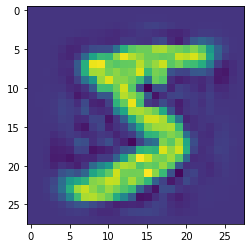

In [0]:
plt.imshow(x_train[0].reshape(28,28))

In [0]:
class ConvDenoiseAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvDenoiseAutoEncoder, self).__init__()
        #encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)  # conv layer (depth from 1 --> 64), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 16, 3, padding=1)  # conv layer (depth from 64 --> 16), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1) # conv layer (depth from 16 --> 8), 3x3 kernels
        self.pool = nn.MaxPool2d(2, 2)
        
        #decoder layers
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2) # two more transpose layers with a kernel of 2
        self.t_conv3 = nn.ConvTranspose2d(16, 64, 2, stride=2)
        self.conv_out = nn.Conv2d(64, 1, 3, padding=1) # one, final, normal conv layer to decrease the depth

    def encode(self, x):
      x = F.relu(self.conv1(x))
      x = self.pool(x)
      x = F.relu(self.conv2(x))
      x = self.pool(x)
      x = F.relu(self.conv3(x))
      x = self.pool(x)
      return x

    def decode(self, x):
      x = F.relu(self.t_conv1(x))
      x = F.relu(self.t_conv2(x))
      x = F.relu(self.t_conv3(x))
      x = torch.sigmoid(self.conv_out(x))
              
      return x


    def forward(self, x):
      x = self.encode(x)
      x = self.decode(x)
      return x
        

In [0]:
def denoisingCNN(dataLoader, epochs=10):
  losses = []
  train_acc = 0
  test_acc = 0

  print("Initializing the network ...")
  net = ConvDenoiseAutoEncoder()
  criterion = nn.MSELoss()

  optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

  print("Training the network ...")
  losses = []

  net.cuda()
  for e in tqdm(range(epochs)):
    train_loss = 0.0
    for data in dataLoader:

      inputs, labels = data
      inputs = inputs.float().cuda()
      labels = labels.float().cuda()
      optimizer.zero_grad()
      # print(inputs.min())
      # print(inputs.max())
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*inputs.size(0)

    losses.append(train_loss/len(dataLoader))
    train_loss = train_loss/len(dataLoader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        e, 
        train_loss
        ))
  plt.plot(losses)
  plt.figure()
  
  return net, outputs, labels, inputs

In [0]:
myDataLoader = create_dataloader(x_train, train_data_clip, batch_sz=20)

Initializing the network ...
Training the network ...


Epoch: 0 	Training Loss: 0.900253
Epoch: 1 	Training Loss: 0.569248
Epoch: 2 	Training Loss: 0.518940
Epoch: 3 	Training Loss: 0.487302
Epoch: 4 	Training Loss: 0.464694
Epoch: 5 	Training Loss: 0.446912
Epoch: 6 	Training Loss: 0.430139
Epoch: 7 	Training Loss: 0.412981
Epoch: 8 	Training Loss: 0.395022
Epoch: 9 	Training Loss: 0.378286



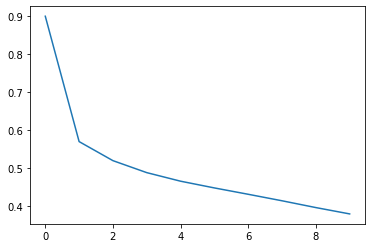

<Figure size 432x288 with 0 Axes>

In [0]:
trained_Model, outputs, origInput , noisy_Input  = denoisingCNN(myDataLoader, epochs=10)

In [0]:
with torch.no_grad():
  test_inputs = torch.Tensor(x_test).view(-1, 1, 28, 28).cuda()
  outputs = trained_Model(test_inputs)

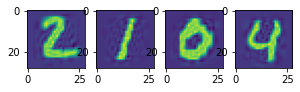

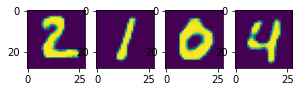

In [0]:
num_examples = 4
plt.figure()
for i in range(1,num_examples+1):
  plt.subplot(1, num_examples+1, i).imshow(test_inputs.cpu()[i].reshape(28,28))

plt.figure()
for i in range(1,num_examples+1):
    plt.subplot(1, num_examples+1, i).imshow(outputs.cpu()[i].reshape(28,28))   

# CNN Code

In [0]:
def eval_CNN(train_loader, test_loader, epochs, batch_size):

  ##### Prepare return values ##################################################
  losses = []
  train_acc = 0
  test_acc = 0

  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
      self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
      self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
      self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
      self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
      self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 16 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.RMSprop(net.parameters(), lr=0.001) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in tqdm(range(epochs)):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad() # zero the parameter gradients
      outputs = net(inputs) # forward pass
      
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update

      losses.append(loss.item())
    print("Epoch: ", e+1, "\t Loss:", loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
    # if True:
      inputs, labels = data
      # inputs = torch.autograd.Variable(torch.from_numpy(inputs))
      # inputs = inputs.float()
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on training data ################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
    # if True:
      inputs, labels = data
      # inputs = torch.autograd.Variable(torch.from_numpy(inputs))
      # inputs = inputs.float()
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc

# Create DataLoader

In [0]:
train_list = []
with torch.no_grad():
  for data, _ in myDataLoader:
    train_inputs = torch.Tensor(data).view(-1, 1, 28, 28).cuda()
    train_denoise = trained_Model(train_inputs)
    train_list.append(train_denoise.cpu())
  
  train_x = torch.cat(train_list, 0)

  test_inputs = torch.Tensor(x_test).view(-1, 1, 28, 28).cuda()
  test_x = trained_Model(test_inputs).cpu()

In [0]:
print(train_x.shape)
print(test_x.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


# Train CNN on Denoised Data

In [0]:
trainLoader = create_dataloader(train_x, train_data.targets, batch_sz=100, image=False)
testLoader = create_dataloader(test_x, test_data.targets, batch_sz=100, image=False)

Initializing the network ...
Training the network ...


Epoch:  1 	 Loss: 0.30594417452812195
Epoch:  2 	 Loss: 0.265470027923584
Epoch:  3 	 Loss: 0.2217540144920349
Epoch:  4 	 Loss: 0.20562197268009186
Epoch:  5 	 Loss: 0.19059516489505768
Epoch:  6 	 Loss: 0.18511129915714264
Epoch:  7 	 Loss: 0.17637550830841064
Epoch:  8 	 Loss: 0.16466264426708221
Epoch:  9 	 Loss: 0.1708029955625534
Epoch:  10 	 Loss: 0.15373463928699493

Evaluating on training data ...
Evaluating on test data ...


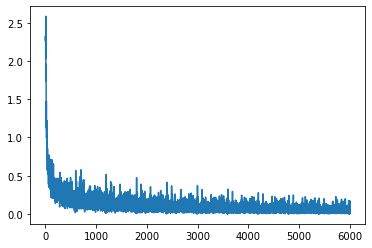

In [0]:
losses, train_acc, test_acc = eval_CNN(trainLoader, testLoader, 10, 100)
plt.plot(losses)

In [0]:
print("Train Acc", train_acc)
print("Train Acc", test_acc)

Train Acc 0.9773333333333334
Train Acc 0.9696


# Train on reconstructed PCA

In [0]:
x_train = train_data.data.numpy()
x_train = x_train.reshape(-1, 28*28)
x_test = test_data.data.numpy()
x_test = x_test.reshape(-1, 28*28)

In [0]:
def inverse_compressUsingPCA(varianceLevel):
  pca = decomposition.PCA(varianceLevel)
  X_pca_train = pca.fit_transform(x_train)
  X_train_reconstruct = pca.inverse_transform(X_pca_train)
  X_pca_test = pca.fit_transform(x_test)
  X_test_reconstruct = pca.inverse_transform(X_pca_test)
  return X_train_reconstruct, X_test_reconstruct

Initializing the network ...
Training the network ...


Epoch:  1 	 Loss: 0.20968647301197052
Epoch:  2 	 Loss: 0.18018434941768646
Epoch:  3 	 Loss: 0.18735402822494507
Epoch:  4 	 Loss: 0.16170935332775116
Epoch:  5 	 Loss: 0.1721351593732834

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9317833333333333
Test accuracy:  0.8882


<Figure size 432x288 with 0 Axes>

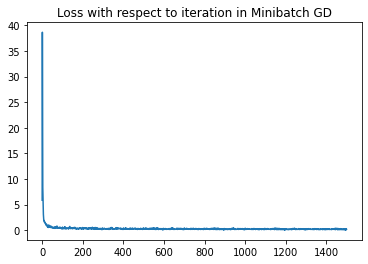

<Figure size 432x288 with 0 Axes>

In [0]:
compressedTrainData, compressedTestData = inverse_compressUsingPCA(0.50)

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets, image=False)
test_loader = create_dataloader(compressedTestData, test_data.targets, image=False)

losses, train_acc, cnn_50_acc = eval_CNN(train_loader, test_loader, epochs=5, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", cnn_50_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

**Inference**

1. CNN with denoised outputs of the denoising auto-encoder performed better than the reconstructed images from PCA, around 10% improvements in the performance.
2. This was because the ouputs from the denoised auto-encoder has less noise when compared to noisy compression of the PCA reconstruction.

References:



*   [Keras Denoising Autoencoder](https://keras.io/examples/mnist_denoising_autoencoder/)
*   [Convolutional Denoising Autoencoder](https://medium.com/activating-robotic-minds/how-to-reduce-image-noises-by-autoencoder-65d5e6de543)

*   [Denoising Autoencoder](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/denoising-autoencoder/Denoising_Autoencoder_Solution.ipynb)